# Predicting Solar Panel Adoption - Data Set Up
#### UC Berkeley MIDS
`Team: Gabriel Hudson, Noah Levy, Laura Williams`

This notebook starts with a public dataset from Stanford's DeepSolar team, available here:  
http://web.stanford.edu/group/deepsolar/home  

In [1]:
# imports
import copy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

%matplotlib inline

In [2]:
# load full dataset
deepsolar_original = pd.read_csv('../deepsolar_tract.csv', index_col=4, encoding='ISO-8859-1')
# remove unused indexing variable at position 0
deepsolar_original.drop(labels='Unnamed: 0', axis=1, inplace=True)

In [3]:
# print dataset shape
original_shape = deepsolar_original.shape
print("Dataset rows and dimensions after indexing:", original_shape)

Dataset rows and dimensions after indexing: (72537, 167)


In [4]:
deepsolar_original.head()

,tile_count,solar_system_count,total_panel_area,average_household_income,county,education_bachelor,education_college,education_doctoral,education_high_school_graduate,education_less_than_high_school,...,incentive_count_nonresidential,incentive_residential_state_level,incentive_nonresidential_state_level,net_metering,feedin_tariff,cooperate_tax,property_tax,sales_tax,rebate,avg_electricity_retail_rate
fips,,,,,,,,,,,,,,,,,,,,,
27145011200,0.0,0.0,0.000000,70352.789869,Stearns County,569,1690,13,1757,336,...,39,11,13,34,0,0,25,12,0,9.46
27145011301,25.0,21.0,1133.436461,61727.085202,Stearns County,674,1434,108,767,222,...,39,11,13,34,0,0,25,12,0,9.46
27145011302,3.0,3.0,64.505776,71496.886583,Stearns County,854,1459,31,1541,289,...,39,11,13,34,0,0,25,12,0,9.46
27145011304,0.0,0.0,0.000000,86840.152755,Stearns County,640,1116,68,1095,231,...,39,11,13,34,0,0,25,12,0,9.46
27145011400,5.0,5.0,164.583303,89135.315597,Stearns County,654,1314,15,982,163,...,39,11,13,34,0,0,25,12,0,9.46


This dataset has 169 variables and 72,537 datapoints. The fifth variable in the dataset is a FIPS number which is used to identify the census tract.  That column is used as the index in the pandas dataframe. The first column is an unneeded integer index variable. After setting up the indexing, the dataset has 167 variables.


Variables include geographic identification variables, various outcome variables, variables used to calculate other variables, and weather, socio-economic, heating, electricity, political, transportation and incentive data.  Datapoints are per census tract. 

## Remove datapoints

Note that the original dataset is not altered after this point in this notebook, all changes are made to the `deepsolar_curated` dataset.  

Census tracts with zero population and/or zero households will not contribute to analysis about residential solar panels.

In [4]:
print("The number of census tracts with a population of zero is", \
      deepsolar_original[deepsolar_original['population'] == 0].shape[0])

The number of census tracts with a population of zero is 597


In [5]:
# remove those census tracts from the dataset
deepsolar_curated = deepsolar_original[deepsolar_original['population'] != 0]
print("Dataset shape after removing population counts of zero:", deepsolar_curated.shape)

Dataset shape after removing population counts of zero: (71940, 167)


In [6]:
print("The number of census tracts with a household_count of zero in the curated dataset is", \
       deepsolar_curated[deepsolar_curated['household_count'] == 0].shape[0])

The number of census tracts with a household_count of zero in the curated dataset is 174


In [7]:
# remove those census tracts from the dataset
deepsolar_curated = deepsolar_curated[deepsolar_curated['household_count'] != 0]
print("Dataset shape after removing household counts of zero:", deepsolar_curated.shape)

Dataset shape after removing household counts of zero: (71766, 167)


Noah found that the model performed better when census tracts with small populations were removed (see `test_pop_limit.py` and `pop_limit.csv`). The most improvement in R squared was seen when removing census tracts with populations less than 100.  Small but erratic improvements to the model were seen when removing census tracts with populations more than 100 but less than 1000. That small improvement may not be significant enough to justify removing those additional datapoints and losing generalization of the model to those census tracts with a population of between 100 and 1000.  

In general, having a minimum sample size of population in any census tract is necessary for the data within that census tract to have a normal distribution.  Without access to the data inside the census tracts, it's not possible to do more extensive statistical analysis to determine best sample size for the population variable of each census tract, and a population of 100 is a reasonable estimate for the best minimum sample size.

In [8]:
print("The number of census tracts with a population of more than zero but less than 100 in the curated dataset is " + \
       str(deepsolar_curated[deepsolar_curated['population'] <= 100].shape[0]) + "\nwhich is " + \
       str(round((deepsolar_curated[deepsolar_curated['population'] <= 100].shape[0]/ \
                  deepsolar_original.shape[0])*100, 2)) + \
       "% of the datapoints of the original dataset.")

The number of census tracts with a population of more than zero but less than 100 in the curated dataset is 91
which is 0.13% of the datapoints of the original dataset.


In [9]:
# remove those census tracts from the dataset
deepsolar_curated = deepsolar_curated[deepsolar_curated['population'] >= 100]
print("Dataset shape after removing population counts of more than zero and less than or equal to 100:", \
      deepsolar_curated.shape)

Dataset shape after removing population counts of more than zero and less than or equal to 100: (71676, 167)


Like population counts, the variable `household_counts` is used to calculate other variables, including the outcome variable, and it's reasonable to estimate that a sample size of less than 100 household in any census tract is not sufficient for that census tract to be a reliable data point.

In [10]:
print("The number of census tracts with households of more than zero but less than 100 in the curated dataset is " + \
       str(deepsolar_curated[deepsolar_curated['household_count'] <= 100].shape[0]) + "\nwhich is " + \
       str(round((deepsolar_curated[deepsolar_curated['household_count'] <= 100].shape[0]/ \
                  deepsolar_original.shape[0])*100, 2)) + \
       "% of the datapoints of the original dataset.")

The number of census tracts with households of more than zero but less than 100 in the curated dataset is 194
which is 0.27% of the datapoints of the original dataset.


In [11]:
# remove those census tracts from the dataset
deepsolar_curated = deepsolar_curated[deepsolar_curated['household_count'] >= 100]
print("Dataset shape after removing household counts of more than zero and less than or equal to 100:", \
      deepsolar_curated.shape)

Dataset shape after removing household counts of more than zero and less than or equal to 100: (71482, 167)


Our interactive tool was not managing well census tracts that are predominantly water. Noah also found that using the `water_percent` variable instead of the the three area variables (`water_area`, `total_area` and `land_area` did not appreciably change the model

In [12]:
# Create variable to calculate water percentage of each census tract
deepsolar_curated['water_percent'] = deepsolar_curated['water_area']/deepsolar_curated['total_area']

In [13]:
print("The number of census tracts more than 75% water is " + \
str(deepsolar_curated[deepsolar_curated['water_percent'] > 0.75].shape[0]) + " which is " + \
str(round((deepsolar_curated[deepsolar_curated['water_percent'] > 0.75].shape[0]/ \
          deepsolar_original.shape[0])*100, 2)) + \
"% of the original dataset.")

The number of census tracts more than 75% water is 153 which is 0.21% of the original dataset.


In [14]:
# remove those census tracts from the dataset
deepsolar_curated = deepsolar_curated[deepsolar_curated['water_percent'] < 0.75]
print("Dataset shape after removing census tracts more than 75% water:", \
      deepsolar_curated.shape)

Dataset shape after removing census tracts more than 75% water: (71305, 168)


In [15]:
# remove the three area variables that contribute to the water_percent variable
deepsolar_curated.drop(labels='land_area', axis=1, inplace=True)
deepsolar_curated.drop(labels='water_area', axis=1, inplace=True)
deepsolar_curated.drop(labels='total_area', axis=1, inplace=True)
deepsolar_curated.shape

(71305, 165)

In [16]:
print("Percentage of datapoints remaining in the curated dataset compared to the original is: "+ \
       str(round((deepsolar_curated.shape[0]/deepsolar_original.shape[0])*100, 2)) + "%")

Percentage of datapoints remaining in the curated dataset compared to the original is: 98.3%


## Define outcome variable

Outcome variable used by DeepSolar that we also initially used ourselves:  
`number_of_solar_system_per_household` --  number of residential solar power systems per household.  This variable is calculated by dividing the `solar_system_count_residential` variable by the `household_count` variable.

In [17]:
# set outcome variable:
outcome_var = 'number_of_solar_system_per_household'

In [18]:
# range of outcome variable:
print("Range of outcome variable 'number_of_solar_system_per_household' is", \
      deepsolar_curated[outcome_var].min(), "to", deepsolar_curated[outcome_var].max())

Range of outcome variable 'number_of_solar_system_per_household' is 0.0 to 0.974226804124


Distribution of outcome variable 'number_of_solar_system_per_household':


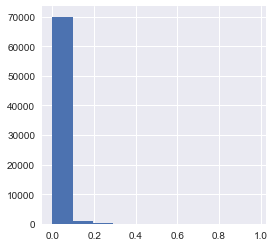

In [21]:
print("Distribution of outcome variable 'number_of_solar_system_per_household':")
deepsolar_curated[outcome_var].replace(np.inf,np.nan).dropna().hist(figsize=(4,4))
plt.show()

## Try a different outcome variable  
Gabe tried modifying the outcome variable to reflect residential structures that are owner-occupied and this improved the accuracy of our model. 

Rationale:   
The `household_count` variable obtained from census data does not strictly correspond with residential structures. This variable can record multiple households within a single residential structure. Unfortunately we were not able to obtain census tract data for residential structures (as opposed to households). Multiplying this original variable by the rate of owner occupancy is the best estimate we could come up with to measure number of solar systems per residential structure rather than per household.

In [22]:
# multiple owner occupied rate times current outcome variable
deepsolar_curated['owner_occupied_solar_system_density'] = deepsolar_curated['occupancy_owner_rate']* \
                                                           deepsolar_curated['number_of_solar_system_per_household']
outcome_var = 'owner_occupied_solar_system_density'

In [23]:
# remove the previously used outcome variable and the occupancy owner rate variable
deepsolar_curated.drop(labels=['occupancy_owner_rate', 'number_of_solar_system_per_household'], 
                       axis=1, inplace=True)

In [24]:
# range of this outcome variable:
print("Range of outcome variable 'owner_occupied_solar_system_density' is", \
      deepsolar_curated[outcome_var].min(), "to", deepsolar_curated[outcome_var].max())

Range of outcome variable 'owner_occupied_solar_system_density' is 0.0 to 0.551749720296


Distribution of outcome variable 'owner_occupied_solar_system_density':


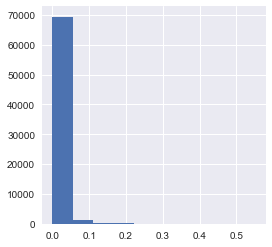

In [25]:
print("Distribution of outcome variable 'owner_occupied_solar_system_density':")
deepsolar_curated[outcome_var].replace(np.inf,np.nan).dropna().hist(figsize=(4,4))
plt.show()

In [30]:
# confirm dataset shape has one less variable than before changing outcome variable
deepsolar_curated.shape

(71305, 164)

## Remove variables

Multiple variables will not contribute to analysis. Reasoning for each variable or set of datapoints removed from the dataset is defined below.

Load variable names from DeepSolar data

In [31]:
# extract variable names from header
deepsolar_header = pd.read_csv('../deepsolar_tract.csv', encoding='ISO-8859-1', nrows=0.).columns.tolist()

In [32]:
print("Number of variables: ", len(deepsolar_header))

Number of variables:  169


In [33]:
# load all variables into a dictionary for curating a variable list
variables_dict = {}
for var in deepsolar_header:
    variables_dict[var] = 1

Load variable metadata from DeepSolar. We referred to this metadata to make choices about some of the variables we removed.

In [34]:
# load variable metadata
deepsolar_meta = pd.read_csv('../deepsolar_tract_meta.csv', encoding='ISO-8859-1')

In [35]:
deepsolar_meta.head()

,column_name,explanation,source
0,tile_count,number of image tiles containing solar power s...,deepsolar
1,solar_system_count,number of solar power systems (after merging),deepsolar
2,total_panel_area,total area of solar panels (m^2),deepsolar
3,fips,census tract FIPS number,ACS 2015 (5-Year Estimates)
4,average_household_income,average annual houshold income ($),ACS 2015 (5-Year Estimates)


### Remove outcome variables

Remaining outcome variables from DeepSolar will not be used in our analysis

In [36]:
variables_dict['tile_count'] = 'Unused outcome variable: number of image tiles containing solar power system'
variables_dict['solar_system_count'] = 'Unused outcome variable: number of solar power systems (after merging)'
variables_dict['total_panel_area'] = 'Unused outcome variable: total area of solar panels (m^2)'
variables_dict['solar_panel_area_divided_by_area'] = 'Unused outcome variable: \
    solar panel area divided by total area (m^2/mile^2)'
variables_dict['solar_panel_area_per_capita'] = 'Unused outcome variable: \
    solar panel area per capita (m^2/capita)'
variables_dict['tile_count_residential'] = 'number of image tiles containing residential solar power system'
variables_dict['tile_count_nonresidential'] = 'Unused outcome variable: \
    number of image tiles containing non-residential solar power system'
variables_dict['solar_system_count_residential'] = 'Unused outcome variable: \
    number of residential solar power systems (after merging)'
variables_dict['solar_system_count_nonresidential'] = 'Unused outcome variable: \
    number of non-residential solar power systems (after merging)'
variables_dict['total_panel_area_residential'] = 'Unused outcome variable: \
    total area of residential solar panels (m^2)'
variables_dict['total_panel_area_nonresidential'] = 'Unused outcome variable: \
    total area of non-residential solar panels (m^2)'

### Remove variables that were used to calculate other variables

In [37]:
variables_dict['education_population'] = 'Used for calculating eduation proportions'
variables_dict['heating_fuel_housing_unit_count'] = 'Used for calculating heating proportions'
variables_dict['population'] = 'Used for calculating population density'
variables_dict['poverty_family_count'] = 'Used for calculating poverty level rate'
variables_dict['household_count'] = 'Used for calculating other household proportions'
variables_dict['housing_unit_count'] = 'Used for calculating other housing unit proportions'
variables_dict['housing_unit_occupied_count'] = 'Used for calculating other occupancy rates'

### Remove count variables
Some variables are counts of items whose proprotions are recorded in another variable

In [38]:
variables_dict['race_asian'] = 'Proportion recorded in another variable: race_asian_rate'
variables_dict['race_black_africa'] = 'Proportion recorded in another variable: race_black_africa_rate'
variables_dict['race_indian_alaska'] = 'Proportion recorded in another variable: race_indian_alaska_rate'
variables_dict['race_islander'] = 'Proportion recorded in another variable: race_islander_rate'
variables_dict['race_other'] = 'Proportion recorded in another variable: race_other_rate'
variables_dict['race_two_more'] = 'Proportion recorded in another variable: race_two_more_rate'
variables_dict['race_white'] = 'Proportion recorded in another variable: race_white_rate'
variables_dict['unemployed'] = 'Proportion recorded in another variable: employ_rate'
variables_dict['poverty_family_below_poverty_level'] = 'Proportion recorded in another variable: \
    poverty_family_below_poverty_level_rate'
variables_dict['heating_fuel_none'] = 'Proportion recorded in another variable: heating_fuel_none_rate'
variables_dict['heating_fuel_other'] = 'Proportion recorded in another variable: heating_fuel_other_rate'
variables_dict['heating_fuel_solar'] = 'Proportion recorded in another variable: heating_fuel_solar_rate'
variables_dict['education_professional_school'] = 'Proportion recorded in another variable: \
    education_professional_school_rate'
variables_dict['employed'] = 'Proportion recorded in another variable: employ_rate'
variables_dict['heating_fuel_coal_coke'] = 'Proportion recorded in another variable: heating_fuel_coal_coke_rate'
variables_dict['heating_fuel_electricity'] = 'Proportion recorded in another variable: heating_fuel_electricity_rate'
variables_dict['heating_fuel_fuel_oil_kerosene'] = 'Proportion recorded in another variable: \
    heating_fuel_fuel_oil_kerosene_rate'
variables_dict['heating_fuel_gas'] = 'Proportion recorded in another variable: heating_fuel_gas_rate'
variables_dict['education_bachelor'] = 'Proportion recorded in another variable: education_bachelor_rate'
variables_dict['education_college'] = 'Proportion recorded in another variable: education_college_rate'
variables_dict['education_doctoral'] = 'Proportion recorded in another variable: education_doctoral_rate'
variables_dict['education_high_school_graduate'] = 'Proportion recorded in another variable: \
    education_high_school_graduate_rate'
variables_dict['education_less_than_high_school'] = 'Proportion recorded in another variable: \
    education_less_than_high_school_rate'
variables_dict['education_master'] = 'Proportion recorded in another variable: education_master_rate'

### Remove variables highly correlated with another variable.
Multiple variables are highly correlated with other variables.  We used a Pearson correlation to identify variables with a Pearson correlation of more than 0.80 for positive correlations or lower than -0.80 for negative correlations, then looked more closely at those specific variables to determine which ones to remove from the dataset.

Create a separate version of the dataset for calculating correlations.

In [40]:
# Remove non-numeric and outcome variables for calculating linear correlations
variables_dict_corr = copy.deepcopy(variables_dict)
variables_dict_corr['state'] = 'non-numeric variable'
variables_dict_corr['county'] = 'non-numeric variable'
variables_dict_corr[outcome_var] = 'Outcome variable'
# create list of variables to be dropped
drop_variables_corr = []
for key,val in variables_dict_corr.items():
    if val!=1:
        drop_variables_corr.append(key)
dropped_var_number = len(drop_variables_corr)
print("Number of variables to be dropped before checking for correlations:", dropped_var_number)
print("After dropping variables, dataset should have", original_shape[1]-dropped_var_number, "dimensions.")
deepsolar_corr = deepsolar_curated.drop(labels=drop_variables_corr, axis=1)
print("Rows and dimensions of dataset for calculating correlations:", deepsolar_corr.shape)

Number of variables to be dropped before checking for correlations: 45
After dropping variables, dataset should have 122 dimensions.
Rows and dimensions of dataset for calculating correlations: (71305, 119)


Calculate linear correlations between variables

In [41]:
# correlation_dataset=deepsolar[variables]
correlation_matrix=deepsolar_corr.corr()

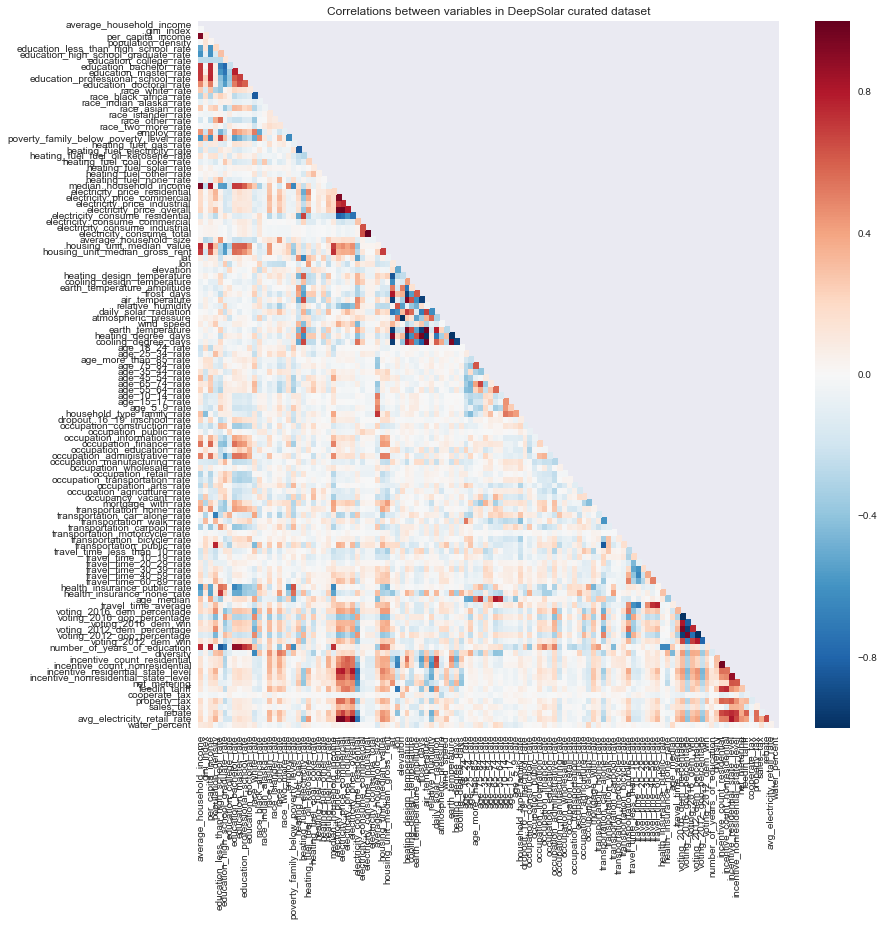

In [42]:
# plot heatmap for correlations
def heatmap(matrix):
    plt.figure(figsize=(13,13))
    mask = np.zeros_like(matrix, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(matrix, mask=mask) 
    plt.title("Correlations between variables in DeepSolar curated dataset")
    plt.show()
heatmap(correlation_matrix)

In [43]:
# calculate pairs of highly correlated variables
correlations=[]
for i in correlation_matrix.index:
    for j in correlation_matrix.columns:
            if i!=j:
                correlations.append((i,j,correlation_matrix[i][j]))
sorted_correlations=sorted(correlations,reverse=True,key=lambda k: k[2])

In [44]:
positive_corr = [i for i in sorted_correlations if i[2] >= 0.8]
print('Top Positive Correlations: ')
for i in positive_corr:
    print(i)

Top Positive Correlations: 
('electricity_consume_industrial', 'electricity_consume_total', 0.99999919377874458)
('electricity_consume_total', 'electricity_consume_industrial', 0.99999919377874458)
('electricity_price_overall', 'avg_electricity_retail_rate', 0.99430213788986777)
('avg_electricity_retail_rate', 'electricity_price_overall', 0.99430213788986777)
('air_temperature', 'earth_temperature', 0.98412544207109498)
('earth_temperature', 'air_temperature', 0.98412544207109498)
('electricity_price_commercial', 'electricity_price_overall', 0.97056979053856984)
('electricity_price_overall', 'electricity_price_commercial', 0.97056979053856984)
('electricity_price_commercial', 'avg_electricity_retail_rate', 0.9656550533433903)
('avg_electricity_retail_rate', 'electricity_price_commercial', 0.9656550533433903)
('electricity_price_residential', 'avg_electricity_retail_rate', 0.96513289409821423)
('avg_electricity_retail_rate', 'electricity_price_residential', 0.96513289409821423)
('frost_

In [45]:
negative_corr = [i for i in sorted_correlations if i[2] <= -0.8]
print('Top Negative Correlations: ')
for i in negative_corr:
    print(i)

Top Negative Correlations: 
('frost_days', 'cooling_degree_days', -0.80762503460169321)
('cooling_degree_days', 'frost_days', -0.80762503460169321)
('voting_2016_gop_percentage', 'voting_2016_dem_win', -0.82096343810600703)
('voting_2016_dem_win', 'voting_2016_gop_percentage', -0.82096343810600703)
('race_white_rate', 'race_black_africa_rate', -0.82912476497729715)
('race_black_africa_rate', 'race_white_rate', -0.82912476497729715)
('heating_fuel_gas_rate', 'heating_fuel_electricity_rate', -0.8312325174375319)
('heating_fuel_electricity_rate', 'heating_fuel_gas_rate', -0.8312325174375319)
('transportation_car_alone_rate', 'transportation_public_rate', -0.83690622247931823)
('transportation_public_rate', 'transportation_car_alone_rate', -0.83690622247931823)
('education_less_than_high_school_rate', 'number_of_years_of_education', -0.85092614247004006)
('number_of_years_of_education', 'education_less_than_high_school_rate', -0.85092614247004006)
('lat', 'heating_design_temperature', -0.8

#### Check assumptions for Pearson correlations before removing any highly correlated variables:
* Linearity: Are variables linearly correlated with each other? Visually: is there a relatively straight line relationship between the two variables?  
* Normal distribution: Do individual variables have a normal distribution?  
* Homoscedasticity: Is a scatterplot evenly distributed around the regression line when a linear model is fitted to the two variables and predictions are plotted against residuals?

In [46]:
# Collect all variables into a list of correlated pairs
correlated_pairs = []
# Because each pair is listed twice, collect every other pair of both top positive and negative correlations
for i in range(len(positive_corr)):
    if i % 2 == 0:
        correlated_pairs.append((positive_corr[i][0], positive_corr[i][1]))
for i in range(len(negative_corr)):
    if i % 2 == 0:
        correlated_pairs.append((negative_corr[i][0], negative_corr[i][1]))
print("Total number of correlated pairs:", len(correlated_pairs))

Total number of correlated pairs: 54


Linearity: create scatterplots of each pair of highly correlated variables

In [47]:
# Separate positive correlations from negative correlations
correlated_pairs_pos = correlated_pairs[:int(len(positive_corr)/2)]
correlated_pairs_neg = correlated_pairs[int(len(positive_corr)/2):]
print("Number of positively correlated pairs:", len(correlated_pairs_pos))
print("Number of negatively correlated pairs:", len(correlated_pairs_neg))

Number of positively correlated pairs: 32
Number of negatively correlated pairs: 22


In [48]:
def scatterplots_linearity (dataset, pairs, correlation_type):
    # set plot sizes
    subplot_cols = 4
    figsize_width = subplot_cols**2
    if len(pairs) <= figsize_width:
        subplot_rows = 4
    else:
        subplot_rows = len(pairs)//subplot_cols + 1
    figsize_height = subplot_rows*subplot_cols
    fig = plt.figure(figsize=(figsize_width, figsize_height))
    # show scatterplot for each pair with linear correlation line
    for i in range(len(pairs)):
        ax = fig.add_subplot(subplot_rows, subplot_cols, i+1)
        ax.scatter(dataset[pairs[i][0]], dataset[pairs[i][1]])
        ax.set(xlabel=pairs[i][0], ylabel=pairs[i][1])
        # add linear baseline
        if correlation_type == 'pos':
            line = mlines.Line2D([0, 1], [0, 1], color='black', linewidth = .3)
            transform = ax.transAxes
        if correlation_type == 'neg':
            line = mlines.Line2D([1,0], [1,0], color='black', linewidth = .3)
            transform = ax.transAxes.inverted()
        line.set_transform(transform)
        ax.add_line(line)
    plt.show()

Scatterplots for positively correlated pairs


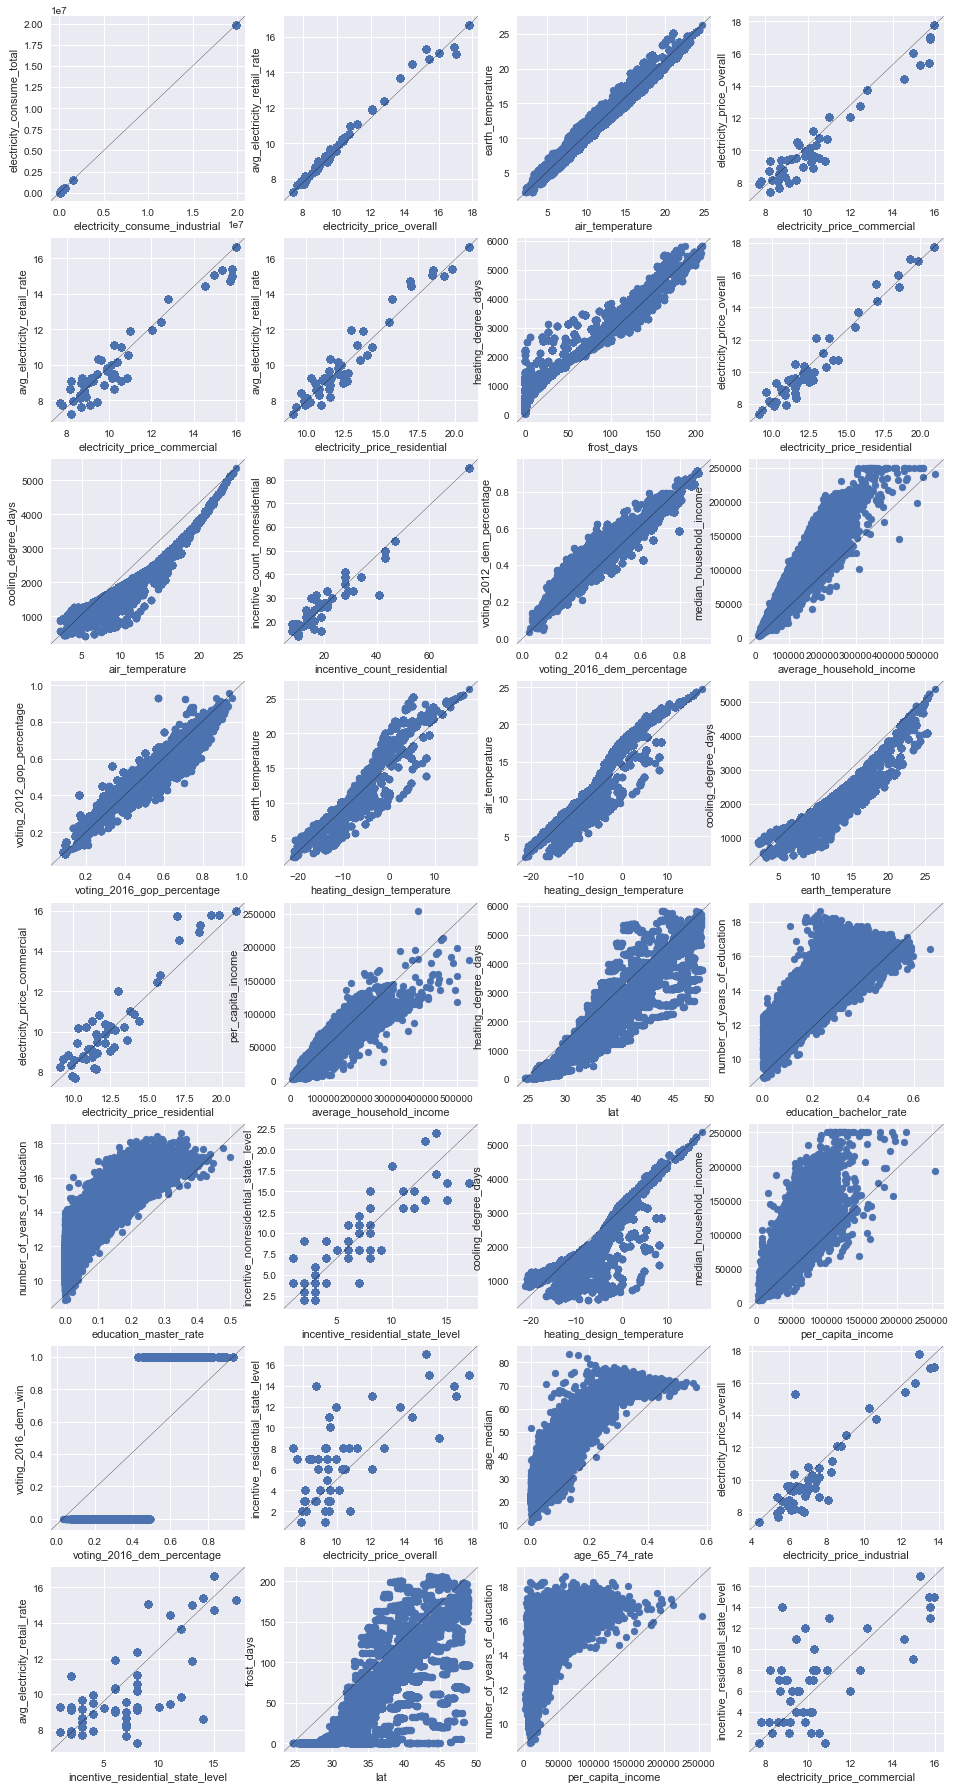

In [49]:
print("Scatterplots for positively correlated pairs")
scatterplots_linearity(deepsolar_curated, correlated_pairs_pos, 'pos')

Scatterplots for negatively correlated pairs


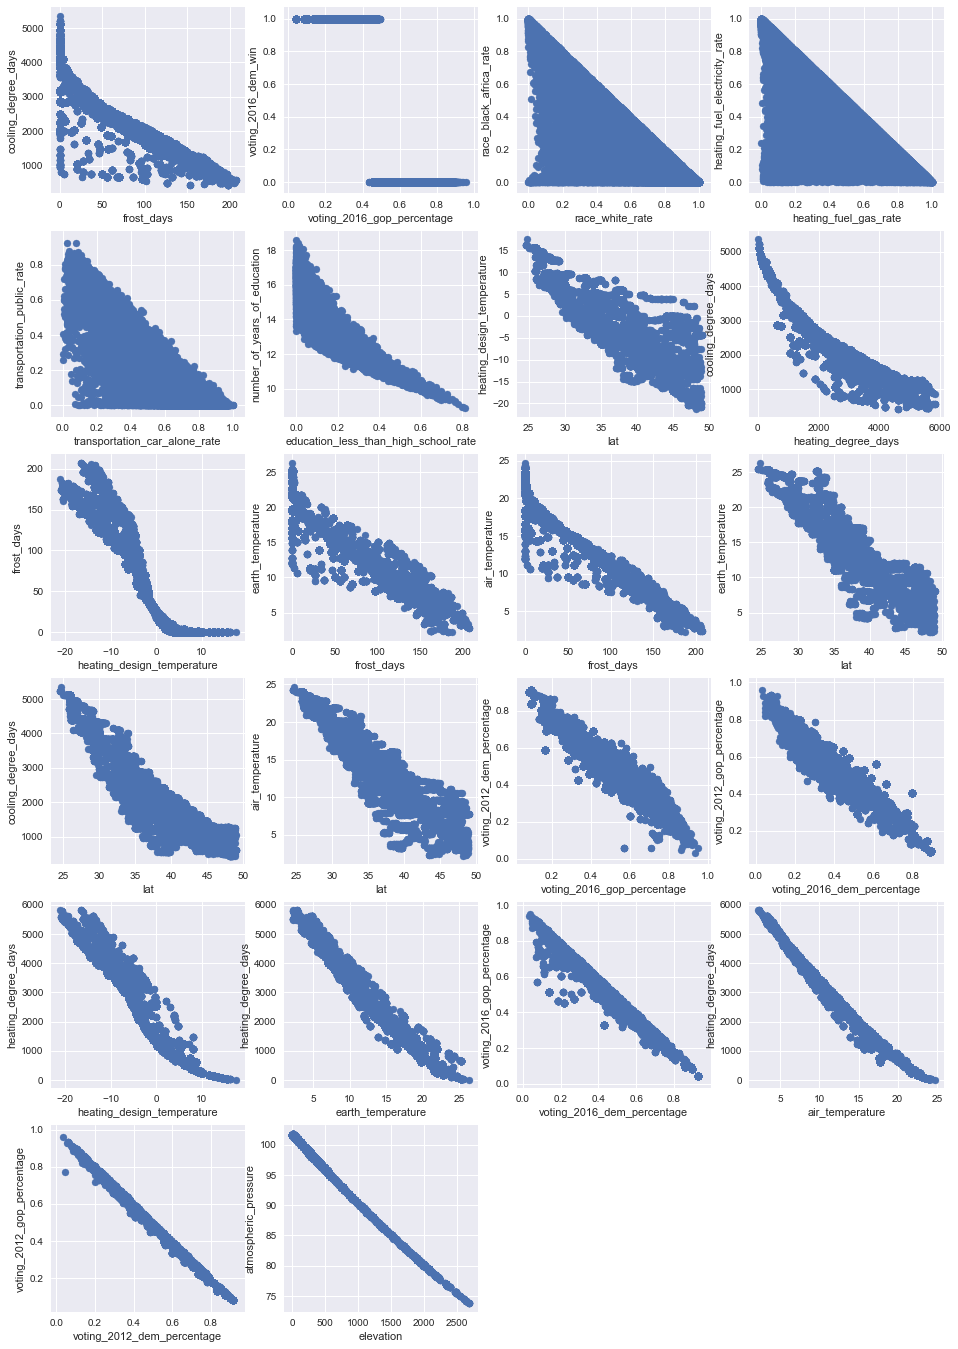

In [50]:
print("Scatterplots for negatively correlated pairs")
scatterplots_linearity(deepsolar_curated, correlated_pairs_neg, 'neg')

Based on visual inspection of the linearity scatterplots above, identify variable pairs that should not be considered highly correlated because the scatterplots do not show enought of a linear correlation.

In [51]:
correlated_pairs.remove(('average_household_income', 'median_household_income'))
correlated_pairs.remove(('education_bachelor_rate', 'number_of_years_of_education'))
correlated_pairs.remove(('education_master_rate', 'number_of_years_of_education'))
correlated_pairs.remove(('per_capita_income', 'median_household_income'))
correlated_pairs.remove(('voting_2016_dem_percentage', 'voting_2016_dem_win'))
correlated_pairs.remove(('age_65_74_rate', 'age_median'))
correlated_pairs.remove(('lat', 'frost_days'))
correlated_pairs.remove(('per_capita_income', 'number_of_years_of_education'))
correlated_pairs.remove(('frost_days', 'cooling_degree_days'))
correlated_pairs.remove(('voting_2016_gop_percentage', 'voting_2016_dem_win'))
correlated_pairs.remove(('race_white_rate', 'race_black_africa_rate'))
correlated_pairs.remove(('heating_fuel_gas_rate', 'heating_fuel_electricity_rate'))
correlated_pairs.remove(('transportation_car_alone_rate', 'transportation_public_rate'))
correlated_pairs.remove(('education_less_than_high_school_rate', 'number_of_years_of_education'))
correlated_pairs.remove(('lat', 'heating_design_temperature'))
correlated_pairs.remove(('heating_degree_days', 'cooling_degree_days'))
correlated_pairs.remove(('heating_design_temperature', 'frost_days'))
correlated_pairs.remove(('frost_days', 'earth_temperature'))
correlated_pairs.remove(('frost_days', 'air_temperature'))

print("Revised number of correlated pairs to consider:", len(correlated_pairs))
#print('Updated list of correlated variables: ')
#for i in correlated_pairs:
#    print(i)

Revised number of correlated pairs to consider: 35


Normal distributions: Plot histograms of all individual variables potentially correlated with another

In [52]:
# Collect all variables into a single list where each one appears only once
correlated_variables = []
for i in correlated_pairs:
    if i[0] not in correlated_variables:
        correlated_variables.append(i[0])
    if i[1] not in correlated_variables:
        correlated_variables.append(i[1])
print("Number of individual variables to examine:", len(correlated_variables))

Number of individual variables to examine: 26


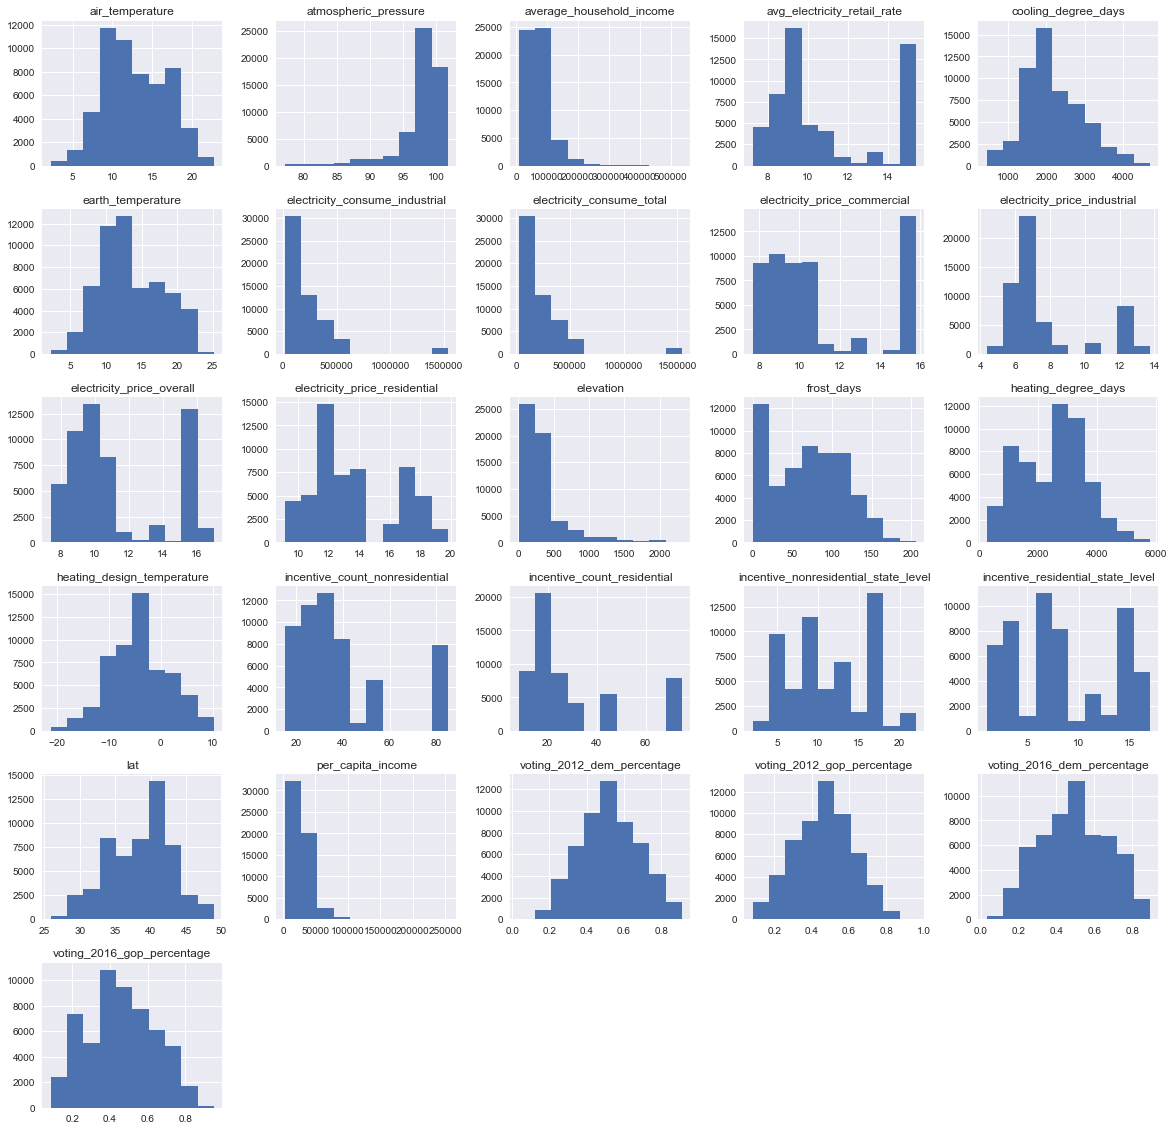

In [53]:
deepsolar_curated[correlated_variables].replace(np.inf,np.nan).dropna().hist(figsize=(20,20))
plt.show()

Based on visual inspection of the distrubions histograms above, identify variables that should not be considered in the highly correlated pairs because they do not have a normal distribution.  



In [54]:
# remove these variables from the list of highly correlated variables
not_normal = ['atmospheric_pressure',
              'average_household_income', 
              'avg_electricity_retail_rate', 
              'electricity_consume_industrial',
              'electricity_consume_total', 
              'electricity_price_commercial', 
              'electricity_price_industrial', 
              'electricity_price_overall', 
              'electricity_price_residential', 
              'elevation',
              'frost_days',
              'incentive_count_nonresidential',
              'incentive_count_residential', 
              'incentive_residential_state_level',
              'incentive_nonresidential_state_level',
              'per_capita_income'
              ]

In [55]:
# Remove the variable pairs in which at least one variable, as listed above, does not have a normal distribution
index_list = []
correlated_pairs_norm = correlated_pairs.copy()
for i in range(len(correlated_pairs)):
    if correlated_pairs[i][0] in not_normal or correlated_pairs[i][1] in not_normal: 
        index_list.append(i)
for i in index_list:
    correlated_pairs_norm.remove(correlated_pairs[i])

print("Revised number of correlated pairs to consider:", len(correlated_pairs_norm))
#print('Updated list of correlated variables: ')
#for i in correlated_pairs_norm:
#    print(i)

Revised number of correlated pairs to consider: 19


In [56]:
# Remove the variables without a normal distribution from the correlated_variables list
correlated_variables_norm = correlated_variables.copy()
for i in range(len(correlated_variables)):
    if correlated_variables[i] in not_normal:
        correlated_variables_norm.remove(correlated_variables[i])

print("Revised number of individual variables in the correlated pairs list:", len(correlated_variables_norm))
for i in correlated_variables_norm:
    print(i)

Revised number of individual variables in the correlated pairs list: 10
air_temperature
earth_temperature
heating_degree_days
cooling_degree_days
voting_2016_dem_percentage
voting_2012_dem_percentage
voting_2016_gop_percentage
voting_2012_gop_percentage
heating_design_temperature
lat


**Homoscedasticity**: Create scatterplots of predicted values vs. residuals for a linear regression of each variable pair.

All remaining variables appear to meet the homoscedasticity assumption.

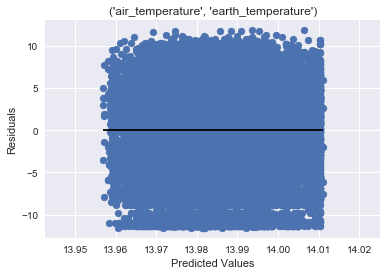

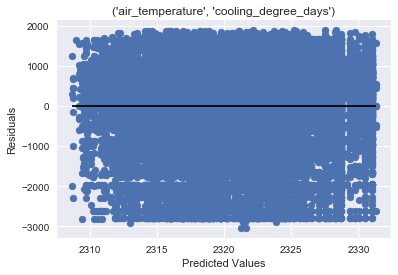

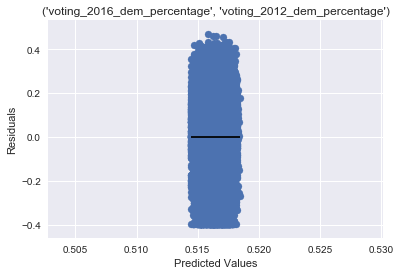

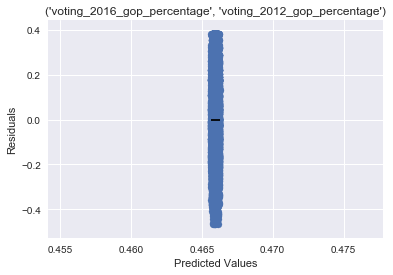

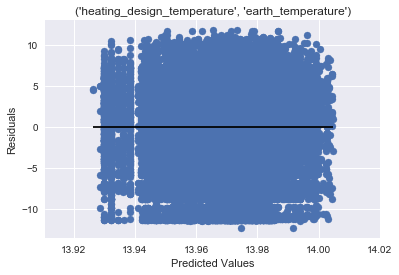

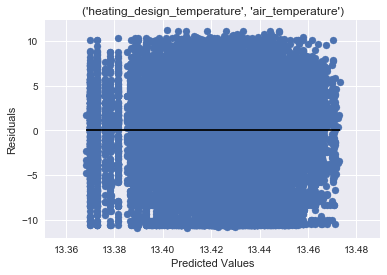

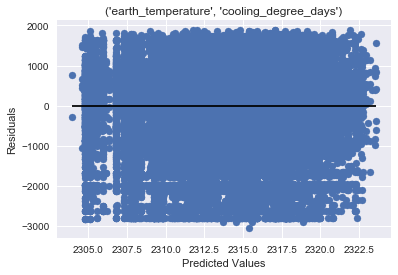

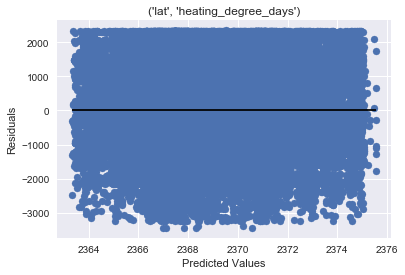

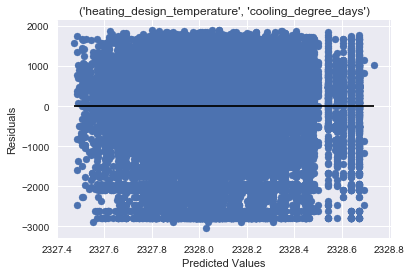

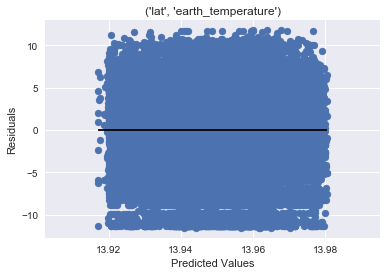

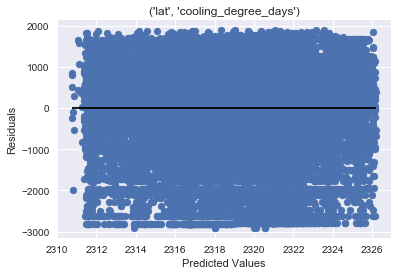

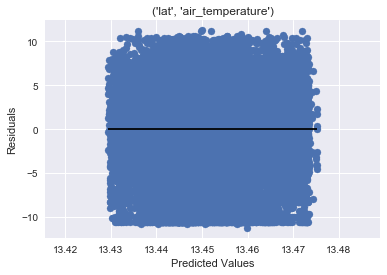

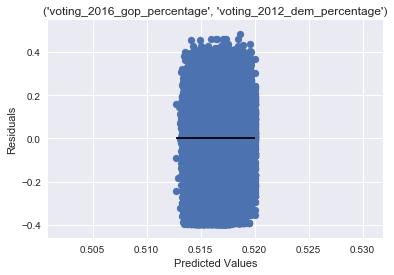

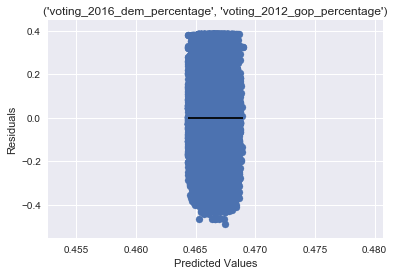

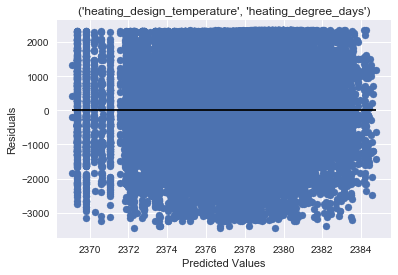

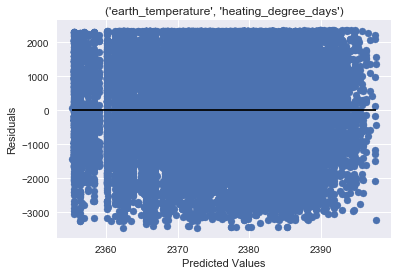

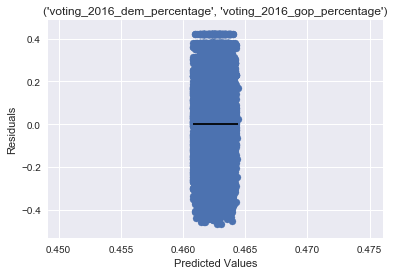

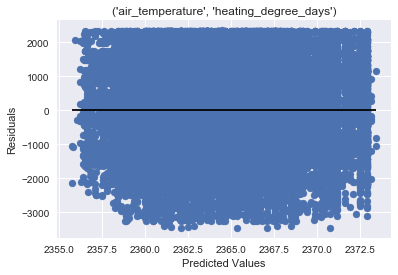

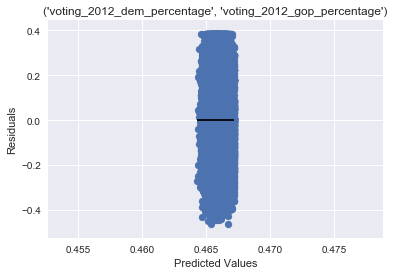

In [57]:
def plot_homoscedasticity(dataset, pairs):
    # Fit linear model and plot predictions vs residuals
    for i in range(len(pairs)):
        X_data = deepsolar_curated[pairs[i][0]].replace(np.inf,np.nan).dropna()
        y_data = deepsolar_curated[pairs[i][1]].replace(np.inf,np.nan).dropna()
        # Take random sample from each variable to keep array lengths the same
        X = np.random.choice(X_data, size=50000)
        y = np.random.choice(y_data, size=50000)
        X = X[:, np.newaxis]
        lr = LinearRegression()
        lr.fit(X,y)
        preds = lr.predict(X)
        residuals = preds-y
        plt.scatter(preds, residuals)
        plt.hlines(y=0, xmin=preds.min(), xmax=preds.max())
        plt.ylabel("Residuals")
        plt.xlabel("Predicted Values")
        plt.title(pairs[i])
        plt.show()

plot_homoscedasticity(deepsolar_curated, correlated_pairs_norm)

Finally, look at each variable plotted against the outcome variable.  If any variables were to show any interesting variation or outliers relative the outcome variable, it might be better not to remove those because their variation may have some value in predicting the outcome variable.

All variables look normally distributed relative to the outcome variable.

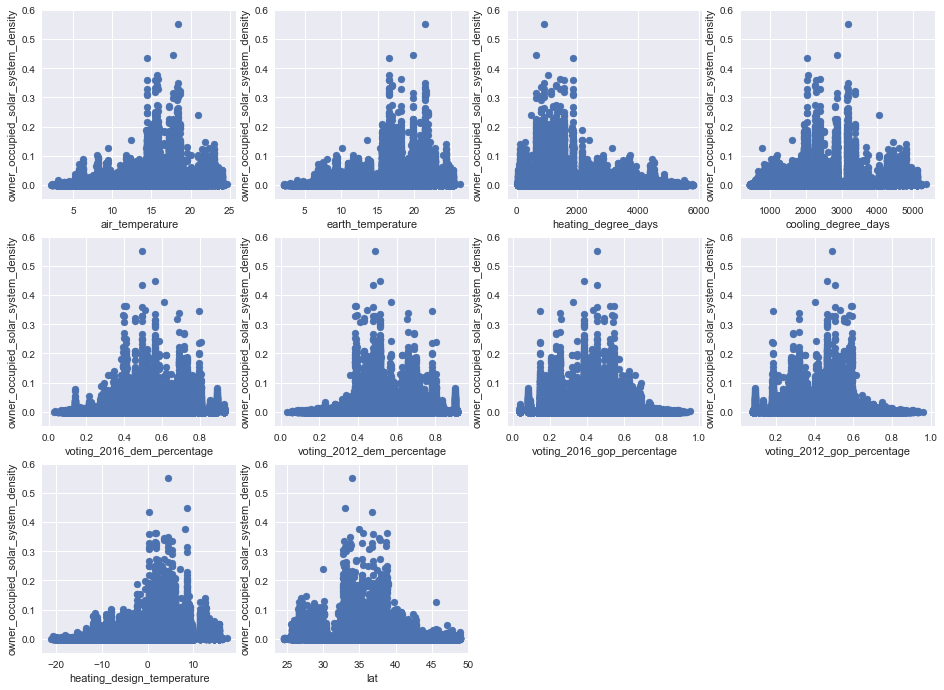

In [58]:
def outcome_plots (dataset, variables, outcome_var):
    # set plot sizes
    subplot_cols = 4
    figsize_width = subplot_cols**2
    if len(variables) <= figsize_width:
        subplot_rows = 4
        figsize_height = 16
    else:
        subplot_rows = len(variables)//subplot_cols + 1
        figsize_height = subplot_rows*4
    fig = plt.figure(figsize=(figsize_width, figsize_height))
    # show scatterplot for each pair with linear correlation line
    for i in range(len(variables)):
        ax = fig.add_subplot(subplot_rows, subplot_cols, i+1)
        ax.set(xlabel=variables[i], ylabel=outcome_var)
        # add scatterplot for variable vs. outcome variable
        ax.scatter(dataset[variables[i]], dataset[outcome_var])
        # add regression line - TO DO
 
    plt.show()


outcome_plots(deepsolar_curated, correlated_variables_norm, outcome_var)

In [59]:
# print final list of highly correlated variables
for i in correlated_pairs_norm:
    print(i)

('air_temperature', 'earth_temperature')
('air_temperature', 'cooling_degree_days')
('voting_2016_dem_percentage', 'voting_2012_dem_percentage')
('voting_2016_gop_percentage', 'voting_2012_gop_percentage')
('heating_design_temperature', 'earth_temperature')
('heating_design_temperature', 'air_temperature')
('earth_temperature', 'cooling_degree_days')
('lat', 'heating_degree_days')
('heating_design_temperature', 'cooling_degree_days')
('lat', 'earth_temperature')
('lat', 'cooling_degree_days')
('lat', 'air_temperature')
('voting_2016_gop_percentage', 'voting_2012_dem_percentage')
('voting_2016_dem_percentage', 'voting_2012_gop_percentage')
('heating_design_temperature', 'heating_degree_days')
('earth_temperature', 'heating_degree_days')
('voting_2016_dem_percentage', 'voting_2016_gop_percentage')
('air_temperature', 'heating_degree_days')
('voting_2012_dem_percentage', 'voting_2012_gop_percentage')


Remaining list of highly correlated variables, grouped by type

**Weather and heating/cooling**  
air_temperature, earth_temperature   
air_temperature, cooling_degree_days  
heating_design_temperature, earth_temperature   
heating_design_temperature, air_temperature   
earth_temperature, cooling_degree_days  
lat, heating_degree_days  
heating_design_temperature, cooling_degree_days  
lat, earth_temperature  
lat, cooling_degree_days  
lat, air_temperature  
heating_design_temperature, heating_degree_days  
heating_design_temperature, cooling_degree_days   
air_temperature, heating_degree_days    

**Political**  
voting_2016_dem_percentage, voting_2012_dem_percentage  
voting_2016_gop_percentage, voting_2012_gop_percentage  
voting_2016_gop_percentage, voting_2012_dem_percentage  
voting_2016_dem_percentage, voting_2012_gop_percentage  
voting_2016_dem_percentage, voting_2016_gop_percentage  
voting_2012_dem_percentage, voting_2012_gop_percentage  

**Discussion:**  
Having highly correlated pairs of variables in a dataset can reduce the accuracy of the model, so ideally one of each pair of these highly correlated variables should be removed from the dataset.

Weather variables:
There are 6 variables highly correlated with each other relative to weather. Given that we have not eliminated longitude from the variable set, it seems reasonable to retain latitude.  Latitude is directly correlated with 4 variables, `heating_degree_days`, `earth_temperature`, `cooling_degree_days`, and `air_temperature`, and all 4 of those are corrleated with the remaining variable, `heating_design_temperature`. We will retain `lat` as a proxy for those other 5 weather variables given their high correlation with each other.

Alternative for weather variables:
If we delete latitude (see discussion below about removing geographic variables), we'll need to retain a different one of these 6 highly correlated variables.  Both `air_temperature` and `earth_temperature` are highly correlated with the other 5 variables, so one of those could be retained instead.

Political variables:
Given that voting in 2012 is highly correlated with 2016, it seems reasonable to remove the 2012 voting data and leave the 2016 data in the dataset, for the somewhat arbitrary reason that 2016 is more recent.
The democratic voting in 2016 is also negatively correlated (-0.99) with gop voting in 2016, so one of those should be removed.

In [60]:
# Remove these variables because they are highly correlated with other variables
variables_dict['earth_temperature'] = 'Positively correlated with lat'
variables_dict['heating_degree_days'] = 'Positively correlated with lat'
variables_dict['cooling_degree_days'] = 'Positively correlated with lat'
variables_dict['air_temperature'] = 'Positively correalted with lat'
variables_dict['heating_design_temperature'] = 'Positively correlated with variables highly correlated with lat'
# alternative weather variables if plan to remove latitude and longitude
#variables_dict['earth_temperature'] = 'Positively correlated with air_temperature'
#variables_dict['heating_degree_days'] = 'Positively correlated with air_temperature'
#variables_dict['cooling_degree_days'] = 'Positively correlated with air_temperature'
#variables_dict['lat'] = 'Positively correalted with air_temperature'
#variables_dict['heating_design_temperature'] = 'Positively correlated with air_temperature'
# political variables
variables_dict['voting_2012_dem_percentage'] = 'Positively correlated with voting_2016_dem_percentage'
variables_dict['voting_2012_gop_percentage'] = 'Positively correlated with voting_2016_gop_percentage'
variables_dict['voting_2016_gop_percentage'] = 'Negatively correalted with voting_2016_dem_percentage'

Remove electricity price, electricity consumption and incentive variables that are not explicitly residential

In [61]:
variables_dict['electricity_price_commercial'] = "Retaining electricity_price_residential in dataset"
variables_dict['electricity_price_industrial'] = "Retaining electricity_price_residential in dataset"
variables_dict['electricity_price_transportation'] = "Retaining electricity_price_residential in dataset"
variables_dict['electricity_price_overall'] = "Retaining electricity_price_residential in dataset"
variables_dict['electricity_consume_commercial'] = "Retaining electricity_consume_residential in dataset"
variables_dict['electricity_consume_industrial'] = "Retaining electricity_consume_residential in dataset"
variables_dict['electricity_consume_total'] = "Retaining electricity_consume_residential in dataset"
variables_dict['incentive_count_nonresidential'] = "Retaining incentive_count_residential in dataset"
variables_dict['incentive_nonresidential_state_level'] = "Retaining incentive_residential_state_level in dataset"

In [62]:
# current shape of dataset
deepsolar_curated.shape

(71305, 164)

Remove all variables itemized above in `variables_dict` from the dataset.

In [63]:
# Convert variable dictionary to list
drop_variables = []
for key,val in variables_dict.items():
    if val!=1:
        drop_variables.append(key)
dropped_var_number = len(drop_variables)
print("Number of variables to be dropped:", dropped_var_number, "\n")
#print("After dropping variables, dataset should have", original_shape[1]-2-dropped_var_number, "variables")
# if using owner-occupied rate variable for calculating outcome variable:
print("After dropping variables, dataset should have", original_shape[1]-3-dropped_var_number, "variables")

Number of variables to be dropped: 59 

After dropping variables, dataset should have 105 variables


In [64]:
deepsolar_curated.drop(labels=drop_variables, axis=1, inplace=True)
print(deepsolar_curated.shape)

(71305, 105)


## Inspect dataset values

In [65]:
# print current dataset variable list
for i in deepsolar_curated.columns.values:
    print(i)

average_household_income
county
gini_index
per_capita_income
population_density
state
education_less_than_high_school_rate
education_high_school_graduate_rate
education_college_rate
education_bachelor_rate
education_master_rate
education_professional_school_rate
education_doctoral_rate
race_white_rate
race_black_africa_rate
race_indian_alaska_rate
race_asian_rate
race_islander_rate
race_other_rate
race_two_more_rate
employ_rate
poverty_family_below_poverty_level_rate
heating_fuel_gas_rate
heating_fuel_electricity_rate
heating_fuel_fuel_oil_kerosene_rate
heating_fuel_coal_coke_rate
heating_fuel_solar_rate
heating_fuel_other_rate
heating_fuel_none_rate
median_household_income
electricity_price_residential
electricity_consume_residential
average_household_size
housing_unit_median_value
housing_unit_median_gross_rent
lat
lon
elevation
cooling_design_temperature
earth_temperature_amplitude
frost_days
relative_humidity
daily_solar_radiation
atmospheric_pressure
wind_speed
age_18_24_rate
age_

In [66]:
# Look at data types for each column
datatypes = deepsolar_curated.dtypes
columns = deepsolar_curated.columns.values
col_datatypes = []
for i in range(len(deepsolar_curated.columns.values)):
    col_datatypes.append((columns[i], datatypes[i]))
for i in col_datatypes:
    print("{:<35}\t{}".format(i[0], i[1]))

average_household_income           	float64
county                             	object
gini_index                         	float64
per_capita_income                  	float64
population_density                 	float64
state                              	object
education_less_than_high_school_rate	float64
education_high_school_graduate_rate	float64
education_college_rate             	float64
education_bachelor_rate            	float64
education_master_rate              	float64
education_professional_school_rate 	float64
education_doctoral_rate            	float64
race_white_rate                    	float64
race_black_africa_rate             	float64
race_indian_alaska_rate            	float64
race_asian_rate                    	float64
race_islander_rate                 	float64
race_other_rate                    	float64
race_two_more_rate                 	float64
employ_rate                        	float64
poverty_family_below_poverty_level_rate	float64
heating_fuel_gas_rate        

Non-numeric variables are:  
`county`, `state` (object)  
`voting_2016_dem_win`, `voting_2012_dem_win` (boolean)

Look first at county and state variables

In [67]:
deepsolar_county_state = deepsolar_curated[['county', 'state']]
print(deepsolar_county_state.shape)

(71305, 2)


In [68]:
# look for blank strings
print("County values with blank string values is", \
       deepsolar_county_state[deepsolar_county_state['county'] == ''].shape[0])
print("State values with blank string values is", \
       deepsolar_county_state[deepsolar_county_state['state'] == ''].shape[0])
# look for missing values
print("County values with missing values is", \
      deepsolar_county_state['county'].isnull().sum())
print("State values with missing values is", \
      deepsolar_county_state['state'].isnull().sum())

County values with blank string values is 0
State values with blank string values is 0
County values with missing values is 0
State values with missing values is 0


Then look at the numeric and boolean variables

In [69]:
deepsolar_numeric = deepsolar_curated.drop(labels=['county', 'state'], axis=1)
print(deepsolar_numeric.shape)

(71305, 103)


In [70]:
# look for infinite values
infinite_values = deepsolar_numeric.apply(lambda x: np.isinf(x)).sum()
for i in infinite_values:
    if i > 0:
        print(i)
# No output means there are no infinite values

In [71]:
# look for percentage of missing data:
missing_data_numeric = deepsolar_numeric.isnull().mean(axis=0).sort_values(ascending=False)
with pd.option_context('display.max_rows', None):
    print(missing_data_numeric)

earth_temperature_amplitude                0.077779
wind_speed                                 0.077779
lon                                        0.077779
elevation                                  0.077779
cooling_design_temperature                 0.077779
frost_days                                 0.077779
relative_humidity                          0.077779
daily_solar_radiation                      0.077779
atmospheric_pressure                       0.077779
lat                                        0.077779
housing_unit_median_gross_rent             0.014249
housing_unit_median_value                  0.012566
dropout_16_19_inschool_rate                0.004558
mortgage_with_rate                         0.003632
median_household_income                    0.000309
travel_time_average                        0.000084
average_household_size                     0.000000
electricity_consume_residential            0.000000
electricity_price_residential              0.000000
owner_occupi

Discussion of missing data:

* 10 variables have about 8% missing data, and these are temperature and latitude/longitude data.  Noah experimented with tracking down weather data and found that adding more precise weather data from the same source DeepSolar got its weather data did not improve the model more than imputing the median for the county.

* 6 remaining variables have less than 1.5% missing data. We could look at the values of other variables for data points with this missing data, or just replace missing data with median values for each variable.

## Impute missing values with medians

In [73]:
# print dataset shape before replacing missing values
deepsolar_curated.shape

(71305, 105)

Replacing missing values with county medians (instead of national medians) very slightly improved the accuracy of the classifier. 

Note: if `air_temperature` was retained instead of `lat` in the highly correlated variables section, adjust commented lines as needed in the code below.


In [74]:
deepsolar_curated[['elevation', 
                  'daily_solar_radiation', 
                  'lat', 
                  #'air_temperature',
                  'lon', 
                  'cooling_design_temperature',
                  'earth_temperature_amplitude', 
                  'frost_days', 
                  'relative_humidity', 
                  'atmospheric_pressure', 
                  'wind_speed',
                  'housing_unit_median_gross_rent',
                  'housing_unit_median_value',
                  'dropout_16_19_inschool_rate',
                  'mortgage_with_rate',
                  'median_household_income',
                  'travel_time_average']] = deepsolar_curated.groupby(['state', 'county']) \
                                                              ['elevation',
                                                               'daily_solar_radiation', 
                                                               'lat', 
                                                               #'air_temperature',
                                                               'lon', 
                                                               'cooling_design_temperature',
                                                               'earth_temperature_amplitude', 
                                                               'frost_days', 
                                                               'relative_humidity', 
                                                               'atmospheric_pressure', 
                                                               'wind_speed',
                                                               'housing_unit_median_gross_rent',
                                                               'housing_unit_median_value',
                                                               'dropout_16_19_inschool_rate',
                                                               'mortgage_with_rate',
                                                               'median_household_income',
                                                               'travel_time_average'
                                                                ] \
                                                               .transform(lambda x: x.fillna(x.median()))

In [75]:
# Confirm missing values have all been replaced
missing_val_count = deepsolar_curated.isnull().sum().sort_values(ascending=False)
for a,b, in missing_val_count.iteritems():
    if b>0:
        print("{:<30}\t{}".format(a,b))
# No output means there is no remaining missing data

cooling_design_temperature    	11
atmospheric_pressure          	11
lat                           	11
lon                           	11
elevation                     	11
earth_temperature_amplitude   	11
frost_days                    	11
relative_humidity             	11
daily_solar_radiation         	11
wind_speed                    	11
housing_unit_median_value     	1
housing_unit_median_gross_rent	1


Imputing values by county and state leaves a small remaining count of missing values. The national median is used to replace those remaining missing values.

In [76]:
# fill in missing lat/lon and weather data with national medians
deepsolar_curated['elevation']. \
    fillna(deepsolar_curated['elevation'].median(), inplace=True)
deepsolar_curated['daily_solar_radiation']. \
    fillna(deepsolar_curated['daily_solar_radiation'].median(), inplace=True)
deepsolar_curated['lat']. \
    fillna(deepsolar_curated['lat'].median(), inplace=True)
#deepsolar_curated['air_temperature']. \
#    fillna(deepsolar_curated['air_temperature'].median(), inplace=True)
deepsolar_curated['lon']. \
    fillna(deepsolar_curated['lon'].median(), inplace=True)
deepsolar_curated['cooling_design_temperature']. \
    fillna(deepsolar_curated['cooling_design_temperature'].median(), inplace=True)
deepsolar_curated['earth_temperature_amplitude']. \
    fillna(deepsolar_curated['earth_temperature_amplitude'].median(), inplace=True)
deepsolar_curated['frost_days']. \
    fillna(deepsolar_curated['frost_days'].median(), inplace=True)
deepsolar_curated['relative_humidity']. \
    fillna(deepsolar_curated['relative_humidity'].median(), inplace=True)
deepsolar_curated['atmospheric_pressure']. \
    fillna(deepsolar_curated['atmospheric_pressure'].median(), inplace=True)
deepsolar_curated['wind_speed']. \
    fillna(deepsolar_curated['wind_speed'].median(), inplace=True)


In [77]:
deepsolar_curated['housing_unit_median_gross_rent']. \
    fillna(deepsolar_curated['housing_unit_median_gross_rent'].median(), inplace=True)
deepsolar_curated['housing_unit_median_value']. \
    fillna(deepsolar_curated['housing_unit_median_value'].median(), inplace=True)
deepsolar_curated['dropout_16_19_inschool_rate']. \
    fillna(deepsolar_curated['dropout_16_19_inschool_rate'].median(), inplace=True)
deepsolar_curated['mortgage_with_rate']. \
    fillna(deepsolar_curated['mortgage_with_rate'].median(), inplace=True)
deepsolar_curated['median_household_income']. \
    fillna(deepsolar_curated['median_household_income'].median(), inplace=True)
deepsolar_curated['travel_time_average']. \
    fillna(deepsolar_curated['travel_time_average'].median(), inplace=True)

In [78]:
# Confirm missing values have all been replaced
missing_val_count = deepsolar_curated.isnull().sum().sort_values(ascending=False)
for a,b, in missing_val_count.iteritems():
    if b>0:
        print("{:<30}\t{}".format(a,b))
# No output means there is no remaining missing data

In [79]:
# confirm dataset shape is the same after replacing missing values
deepsolar_curated.shape

(71305, 105)

We tried replacing missing values with values from the closest FIPS (census tract) code.  This turned out to be less accurate than using county medians.

In [173]:
#deepsolar_fips_sort = deepsolar_curated.sort_index()
#deepsolar_fips_sort.head(3)

In [112]:
#deepsolar_fips_sort.fillna(method='bfill', inplace=True)
#deepsolar_fips_sort.shape

In [115]:
# reshuffle dataset so it's not in order of the FIPS code
# from sklearn.utils import shuffle
# replace current curated dataset with shuffled
#deepsolar_curated = shuffle(deepsolar_fips_sort)
#print(deepsolar_curated.shape)

(71305, 106)


### Convert string variables (county and state) to numeric values

In [80]:
# Encode string features (county and state) into numeric features
LE = preprocessing.LabelEncoder()

LE.fit(deepsolar_curated['county'])
deepsolar_curated['county'] = LE.transform(deepsolar_curated['county'])

LE.fit(deepsolar_curated['state'])
deepsolar_curated['state'] = LE.transform(deepsolar_curated['state'])

print("Confirm dataset shape has not changed after inspecting and modifying values:", deepsolar_curated.shape)

Confirm dataset shape has not changed after inspecting and modifying values: (71305, 105)


### Normalize variables

In [81]:
# normalize all variables except outcome variable
# remove outcome variable so that only features are normalized
deepsolar_final = deepsolar_curated.drop(labels=outcome_var, axis=1)
print("Dataset shape after removing variables:", deepsolar_final.shape)
# normalize
deepsolar_final = (deepsolar_final - deepsolar_final.mean())/(deepsolar_final.max() - deepsolar_final.min())
# Add outcome variable back in from un-normalized dataset
deepsolar_final[outcome_var] = deepsolar_curated[outcome_var]
print("Dataset shape after adding variables back in:", deepsolar_final.shape)

Dataset shape after removing variables: (71305, 104)
Dataset shape after adding variables back in: (71305, 105)


In [82]:
# Confirm outcome variable is not normalized
print("Outcome variable minimum is:", deepsolar_final[outcome_var].min())
print("Outcome variable maximum is:", deepsolar_final[outcome_var].max())

Outcome variable minimum is: 0.0
Outcome variable maximum is: 0.551749720296


## Try removing geographic variables

Latitude, longitude and county were in the top 20 feature importances for the regressor. While geographic trends are clear, if we want to find out what's behind those geographic trends we can try removing geographic variables. This requires amending the highly correlated variables above to remove latitude and instead retain the air temperature variables, and then removing other geographic variables.

**Results**  
Removing the county and state variables (either one at a time or together) did not significantly change the R squared value of the model, so removing those do not detract from the model and might allow for other importance features to become more apparnet.  

Removing either latitude or longitude, however, reduced the R squared score of the model, indicating that there may be other confounding variables not included in the dataset that are currently represented by latitude and longitude, but are not correlated with county or state.

In [83]:
# remove county and state variables
geographic_vars = ['county', 'state']
deepsolar_final.drop(labels=geographic_vars, axis=1, inplace=True)
print(deepsolar_final.shape)

(71305, 103)


## Remove variables identified with L1 regularization linear model

When training a linear regression model using an L1 penalty and gradient descent, the coefficients of the following variables were reduced to zero. Removing these variables has not significantly changed the R squared of the model (pending hypertuning for the revised dataset).  

See "Feature Selection with L1 Regularization" notebook for more detail about removing these variables.  

In [84]:
# save this version of the dataset for input into the L1 regularization linear model
deepsolar_final.to_csv('../Datasets/deepsolar_LW1_new_outcome_var.csv')

In [85]:
# L1 regularization stage 1 drop list
feature_drop_list = ['average_household_income', 'gini_index', 'education_less_than_high_school_rate', 
                     'education_professional_school_rate', 'education_doctoral_rate', 'race_indian_alaska_rate', 
                     'race_islander_rate', 'employ_rate', 'heating_fuel_other_rate', 'electricity_price_residential', 
                     'housing_unit_median_value', 'elevation', 'cooling_design_temperature', 'atmospheric_pressure', 
                     'age_more_than_85_rate', 'age_45_54_rate', 'age_55_64_rate', 'age_15_17_rate', 
                     'occupation_public_rate', 'occupation_agriculture_rate', 'transportation_home_rate', 
                     'transportation_car_alone_rate', 'transportation_walk_rate', 'transportation_motorcycle_rate', 
                     'transportation_bicycle_rate', 'travel_time_less_than_10_rate', 'travel_time_40_59_rate', 
                     'health_insurance_public_rate', 'travel_time_average', 'number_of_years_of_education', 
                     'diversity']

deepsolar_final.drop(labels=feature_drop_list, axis=1, inplace=True)
print(deepsolar_final.shape)

(71305, 72)


In [86]:
# save dataset after Stage 1 for second input into the L1 regularization linear model
deepsolar_final.to_csv('../Datasets/deepsolar_LW1_new_outcome_var_S1.csv')

In [89]:
# L1 regularization stage 2 drop list
feature_drop_list2 = ['race_asian_rate', 'age_75_84_rate', 'age_10_14_rate', 'age_5_9_rate', 'occupation_finance_rate', 
                     'travel_time_30_39_rate', 'travel_time_60_89_rate', 'voting_2016_dem_win', 'voting_2012_dem_win']

deepsolar_final.drop(labels=feature_drop_list2, axis=1, inplace=True)
print(deepsolar_final.shape)

(71305, 63)


In [90]:
# save dataset after Stage 2 for third input into the L1 regularization linear model
deepsolar_final.to_csv('../Datasets/deepsolar_LW1_new_outcome_var_S2.csv')

In [93]:
# L1 regularization stage 3 drop list
feature_drop_list3 = ['race_white_rate', 'age_18_24_rate', 'dropout_16_19_inschool_rate', 
                      'occupation_manufacturing_rate']

deepsolar_final.drop(labels=feature_drop_list3, axis=1, inplace=True)
print(deepsolar_final.shape)

(71305, 59)


Below are the variables removed from the dataset using the original outcome variable - do not run these code blocks after using the previous code blocks.

In [180]:
# L1 regularization stage 1 drop list
feature_drop_list = ['average_household_income', 'education_professional_school_rate', 'education_doctoral_rate', 
                     'race_indian_alaska_rate', 'race_islander_rate', 'heating_fuel_other_rate', 
                     'electricity_price_residential', 'cooling_design_temperature', 'atmospheric_pressure', 
                     'age_25_34_rate', 'age_more_than_85_rate', 'age_75_84_rate', 'age_15_17_rate', 'age_5_9_rate', 
                     'occupation_manufacturing_rate', 'occupation_agriculture_rate', 'transportation_home_rate', 
                     'transportation_car_alone_rate', 'transportation_walk_rate', 'transportation_bicycle_rate', 
                     'health_insurance_public_rate', 'travel_time_average', 'number_of_years_of_education', 
                     'water_percent']

deepsolar_final.drop(labels=feature_drop_list, axis=1, inplace=True)
print(deepsolar_final.shape)

(71305, 79)


In [181]:
# L1 regularization stage 2 drop list
feature_drop_list2 = ['gini_index', 'per_capita_income', 'employ_rate', 'housing_unit_median_value', 'elevation', 
                      'age_10_14_rate', 'dropout_16_19_inschool_rate', 'occupation_construction_rate', 
                      'occupation_public_rate', 'occupation_administrative_rate', 'occupation_retail_rate', 
                      'transportation_motorcycle_rate', 'travel_time_20_29_rate', 'age_median', 'voting_2016_dem_win', 
                      'diversity']

deepsolar_final.drop(labels=feature_drop_list2, axis=1, inplace=True)
print(deepsolar_final.shape)

(71305, 63)


In [182]:
# L1 regularization stage 3 drop list
feature_drop_list3 = ['race_asian_rate', 'earth_temperature_amplitude', 'occupation_finance_rate', 
                      'travel_time_less_than_10_rate']

deepsolar_final.drop(labels=feature_drop_list3, axis=1, inplace=True)
print(deepsolar_final.shape)

(71305, 59)


In [ ]:
# L1 regularization experiment list - we didn't end up using this
feature_drop_list4 = ['population_density', 'education_less_than_high_school_rate', 'race_white_rate', 
                      'heating_fuel_electricity_rate', 'lat', 'age_18_24_rate', 'age_45_54_rate', 
                      'occupation_wholesale_rate', 'transportation_carpool_rate', 'travel_time_30_39_rate', 
                      'travel_time_40_59_rate', 'travel_time_60_89_rate', 'voting_2012_dem_win']

deepsolar_final.drop(labels=feature_drop_list4, axis=1, inplace=True)
print(deepsolar_final.shape)

## Print final variable list

In [94]:
print("There are", len(deepsolar_final.columns.values), "variables in the dataset:")
for i in deepsolar_final.columns.values:
    print(i)

There are 59 variables in the dataset:
per_capita_income
population_density
education_high_school_graduate_rate
education_college_rate
education_bachelor_rate
education_master_rate
race_black_africa_rate
race_other_rate
race_two_more_rate
poverty_family_below_poverty_level_rate
heating_fuel_gas_rate
heating_fuel_electricity_rate
heating_fuel_fuel_oil_kerosene_rate
heating_fuel_coal_coke_rate
heating_fuel_solar_rate
heating_fuel_none_rate
median_household_income
electricity_consume_residential
average_household_size
housing_unit_median_gross_rent
lat
lon
earth_temperature_amplitude
frost_days
relative_humidity
daily_solar_radiation
wind_speed
age_25_34_rate
age_35_44_rate
age_65_74_rate
household_type_family_rate
occupation_construction_rate
occupation_information_rate
occupation_education_rate
occupation_administrative_rate
occupation_wholesale_rate
occupation_retail_rate
occupation_transportation_rate
occupation_arts_rate
occupancy_vacant_rate
mortgage_with_rate
transportation_carpool

## Save dataset to CSV
Save dataset to a CSV file that can be loaded for training models.  

In [95]:
deepsolar_final.to_csv('../Datasets/deepsolar_LW2_new_outcome_plus_L1_S3.csv')